Importar librerias y dependencias necesarias

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import matplotlib.pyplot as plt
import time
import os
import tensorflow as tf
from tensorflow import keras
from scipy.spatial import distance

#Cargar red entreneda

Esto se realiza debido a que se guardaron los pesos de nuestra red creada para así poder usarlos en diferentes notebook y aumentar la productividad como también ir trabajando en diferentes roles manteniendo la conexión, con modelos actualizados.

**Se define el modelo creado por nosotros**

In [ ]:
# Definimos nuestro modelo
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(200, (3, 3), activation='elu', padding='same', input_shape=(50, 50, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(100, (3, 3), activation='elu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((3, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(100, (3, 3), activation='elu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(50, activation='elu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))

  opt = tf.keras.optimizers.Adam()
  model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

  return model

# Creamos un modelo basico
model = create_model()

# Mostramos la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 200)       5600      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 200)       800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 100)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 100)         400       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 100)         0

**Se cargan los pesos haciendo uso de la función load_weights() pasando como parametro un archivo .ckpt donde se guardaron los pesos.**

In [ ]:
#checkpoint_path = "/content/drive/MyDrive/proyecto IA2/cp.ckpt"
checkpoint_path = "/content/drive/MyDrive/proyecto IA2/new_mobil.h5"

model.load_weights(checkpoint_path)

In [ ]:
new_model = keras.models.load_model('/content/drive/MyDrive/proyecto IA2/new_mobil.h5')

# **Clasificación con HaarCascade frontal_face y Mejor Red entrenada**

En esta parte el objetivo es recortar las caras con las coordenadas que nos devuelve el haar cascade classifier de la imagen original, así obtenemos las caras de la imagenes y luego se el envía una por una a la red donde nos dice si o no tiene puesto el tapabocas, así al vamos sobreponiendo encima de la imagen original hasta tener todas las caras clasificadas con o si tienen tapabocas.

**Inicializamos el modelo de detección de caras Haar Cascade en donde openCV un xml por defecto llamado frontal_face.xml** 


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

**Como prueba del haar cascade donde detecta los rostros de una imagen, probamos con una foto que se encuentra en la carpeta drive**

Iniciamos creando nuestras etiquetas de si tiene o no tapabocas, y un color representativo para el marco

In [ ]:
mask_label = {0:'NO MASK',1:'MASK'}
dist_label = {0:(0,255,0),1:(0,0,255)}
MIN_DISTANCE = 200

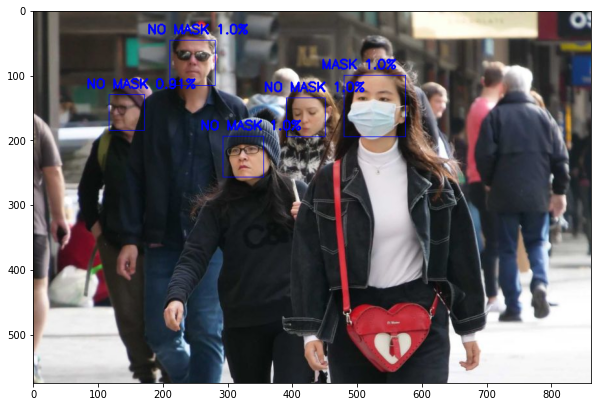

In [ ]:
img = cv2.imread('/content/drive/MyDrive/proyecto IA2/12415442-3x2-xlarge.jpg')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(img,scaleFactor=1.08, minNeighbors=6)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(100,100))
        crop = np.reshape(crop,[1,100,100,3])/255.0
        mask_result = new_model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()]+' '+str(round(np.max(mask_result),2))+'%',(x-35, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.67,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
else:
    print("No. of faces detected is less than 2")

##**Funciones para el funcionamiento del la cámara**

**Función para convertir un objeto de javascript a una imagen que pueda ser leida por OpenCV**

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

**Función para convertir la imagen del rectangulo delimitador dado por OpenC en una cadena de bytes en base 64 para sobreponerla en la transmisión de video o resultado de la imagen.**

In [ ]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

##**Clasificación Cápturas de la cámara**

Se define una función take_photo() dada por google collab que habilite el uso de la cámara además se agrega variables tipo html para mostrar el botón de captura y un recuadro donde se muestra lo que la cámara esta grabando. Internamente esta el clasificador haarcascade devolviendo las coordenadas de las caras las cuales procedemos a recortarlas y armas nuevas imagenes de solo la cara para pasarla a clasificar con nuetra red, donde si esta con mascará devuelve "Mask" y si no "No Mask" y el porcentaje del cual la red clasificó.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  #get Class
  #get Percent 

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=4)

  #print(result)
  # draw face bounding box on image
  if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(50,50))
        crop = np.reshape(crop,[1,50,50,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()]+' '+str(round(np.max(mask_result),2))+'%',(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.67,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
  else:
    print("No. of faces detected is less than 2")
    
  # save image
  cv2.imwrite(filename, new_img)

  return filename

Código para iniciar la cámara y al momento de dar capturar ejecutar take_photo() donde provee la imagen con los rostros marcados en rectangulo y su respectiva clasifcación con tapabocas

<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/proyecto IA2/photo31.jpg


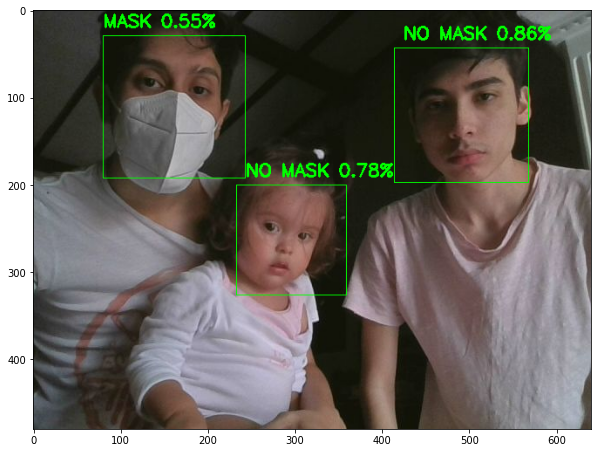

In [ ]:
try:
  filename = take_photo('/content/drive/MyDrive/proyecto IA2/photo31.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Clasificación en tiempo real (Video)

**Función para la reprodución de video, mediante html se crea el espacio para la vista en tiempo real del video, se accede a la cámara del pc**

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

**Damos inicio a la función donde corre en tiempo real lo captado por la camará e interneamente se va recortando con ayuda de las coodernadas dadas por el clasificador haar cascade las caras que se encuentren en la fotograma, donde despues se envían a clasificar con la red, esta devuelve si tiene o no tapabocas, y se dispone a mostrar el fotograma con el rectangulo sobrepuesto y su respectiva etiqueta**

In [ ]:
# Iniciar video desde la cámara del pc
video_stream()
# Texto para mostrar que se esta mostrando en tiempo real
label_html = 'Capturing...'
# inicializamos nuestro delimitador vacio
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convertimos con la función de una imagen en javascript a formato para OpenCV
    img = js_to_image(js_reply["img"])

    # creamos un capa transparente donde agregaremos 
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # convertimos la imagen a escala de grises para enviarlo al haar cascade
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #redimensionamos la imagen para la entrada a nuestra red
    resized_img=(cv2.resize(img,(50,50)))/255.0
    img3 = np.reshape(resized_img,[1,50,50,3])

    # Obtener las coordenadas cuando se detecte una cara  
    faces = face_cascade.detectMultiScale(gray)

    # realizamos un for para recorrer todas las coordenadas encontradas por el detector, sabiendo si hay mas de una cara
    # en la cámara

    if len(faces)>=1:
      label = [0 for i in range(len(faces))]
      for i in range(len(faces)-1):
          for j in range(i+1, len(faces)):
              dist = distance.euclidean(faces[i][:2],faces[j][:2])
              if dist<MIN_DISTANCE:
                  label[i] = 1
                  label[j] = 1
      new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
      for i in range(len(faces)):
          (x,y,w,h) = faces[i]
          crop = new_img[y:y+h,x:x+w]
          crop = cv2.resize(crop,(100,100))
          crop = np.reshape(crop,[1,100,100,3])/255.0
          mask_result = new_model.predict(crop)
          bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),dist_label[label[i]],1)
          cv2.putText(bbox_array,mask_label[mask_result.argmax()]+' '+str(round(np.max(mask_result),2))+'%',(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.67,dist_label[label[i]],2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convertimos la superposición de bbox en bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # actualizamos el bbox para que en el siguiente fotograma tenga una nueva superposición
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

#Detección haciendo uso de un haar cascade con un xml personalizadi, que en vez de detectar caras, detecta tapabocas

**Inicializamos el modelo de detección de caras Haar Cascade con el xml personalizado para la detección de tapabocas.** 


In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/proyecto IA2/HaarCascadeTest/classifier/cascade.xml')

**Como prueba del haar cascade donde detecta los rostros de una imagen, probamos con una foto que se encuentra en la carpeta drive**

[[490 135  74  74]]


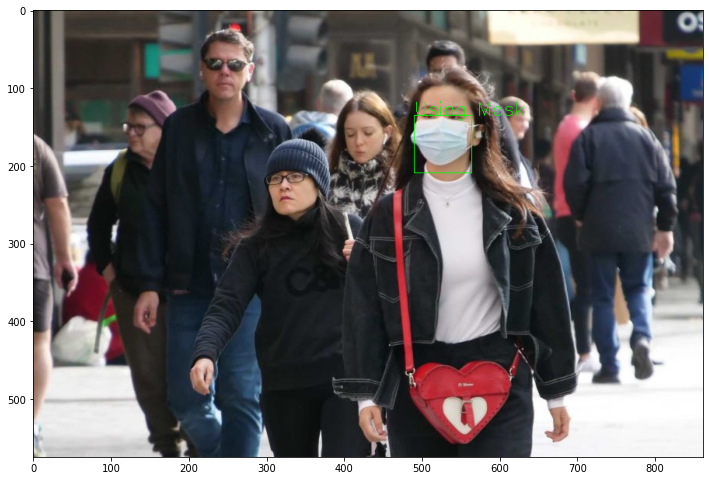

In [ ]:
img = cv2.imread('/content/drive/MyDrive/proyecto IA2/12415442-3x2-xlarge.jpg')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(faces)
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,255,0),1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img, 'Using Mask',(x,y), font,0.8,(0,255,0))
plt.figure(figsize=(12,12))
plt.imshow(out_img)

##**Clasificación Cápturas de la cámara**

Se define una función take_photo() dada por google collab que habilite el uso de la cámara además se agrega variables tipo html para mostrar el botón de captura y un recuadro donde se muestra lo que la cámara esta mirando. Además internamente esta el haar cascade devolviendo el rectangulo luego este se sobrepone en la foto tomada donde este haya captado una cará además de esto se pasa a clasificar si tiene o no tapabocas.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=4)

  #print(result)
  # draw face bounding box on image
  for(x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color=img[y:y+h, x:x+w]
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Using Mask',(x+20,y-10), font,0.5,(255,0,0))
  font = cv2.FONT_HERSHEY_SIMPLEX

  # save image
  cv2.imwrite(filename, img)

  return filename

Código para iniciar la cámara y al momento de dar capturar ejecutar take_photo() devolver la imagen con el rectangulo diciendo si tiene o no tapabocas

<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/proyecto IA2/photo31.jpg


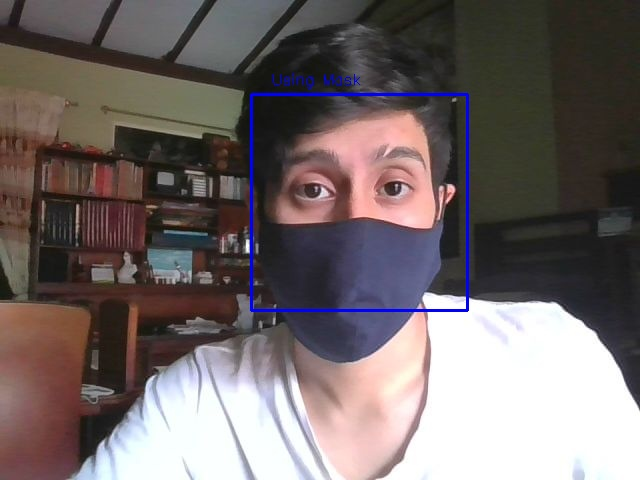

In [ ]:
try:
  filename = take_photo('/content/drive/MyDrive/proyecto IA2/photo31.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Clasificación en tiempo real (Video)

**Función para la reprodución de video, mediante html se crea el espacio para la vista en tiempo real del video, se accede a la cámara del pc**

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

**Damos inicio a la función donde corre en tiempo real lo captado por la camará y vamos calculado caras con el haar cascade hasta encontrar una y pasas a clasificar si esta tiene o no tapabocas**

In [ ]:
# Iniciar video desde la cámara del pc
video_stream()
# Texto para mostrar que se esta mostrando en tiempo real
label_html = 'Capturing...'
# inicializamos nuestro delimitador vacio
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convertimos con la función de una imagen en javascript a formato para OpenCV
    img = js_to_image(js_reply["img"])

    # creamos un capa transparente donde agregaremos 
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # convertimos la imagen a escala de grises para enviarlo al haar cascade
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #redimensionamos la imagen para la entrada a nuestra red
    resized_img=(cv2.resize(img,(50,50)))/255.0
    img3 = np.reshape(resized_img,[1,50,50,3])

    # Obtener las coordenadas cuando se detecte una cara  
    faces = face_cascade.detectMultiScale(gray)

    # realizamos un for para recorrer todas las coordenadas encontradas por el detector, sabiendo si hay mas de una cara
    # en la cámara

    for(x,y,w,h) in faces:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color=img[y:y+h, x:x+w]
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(bbox_array, 'Using Mask',(55,280), font,0.5,(255,0,0))
    font = cv2.FONT_HERSHEY_SIMPLEX


    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convertimos la superposición de bbox en bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # actualizamos el bbox para que en el siguiente fotograma tenga una nueva superposición
    bbox = bbox_bytes

<IPython.core.display.Javascript object>